# Crude Oil Prices - Time Series & Forecasting Problem

## Objective

The main goal is to predict future Crude Oil Prices based on the historical data available in the dataset.

I compared the results using different forecasting models such as LSTM, ARIMA, SARIMA and Prophet. And I selected the best between them.

## Dataset

The crude oil price movements are subject to diverse influencing factors. This dataset was retrieved from the U.S. Energy Information Administration: Europe Brent Spot Price FOB (Dollars per Barrel)

The data contains daily Brent oil prices from 17th of May 1987 until the 13th of November 2022.

You can download this dataset in this link: https://www.kaggle.com/datasets/mabusalah/brent-oil-prices

In [2]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

In [3]:
# Reading the file
#dataset = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
dataset = 'BrentOilPrices.csv'
df = pd.read_csv(dataset)
print(df.shape)
df.head()

(9011, 2)


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [4]:
df = df.rename(columns={'Date': 'ds', 'Price': 'y'})

In [5]:
# Generating of the dataframe complete
df["y_log"] = df["y"].apply(np.log)
df["y_log_diff"] = df["y_log"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)
df["ds"] = pd.to_datetime(df["ds"])
df.dropna(inplace = True, axis = "rows")
df.head()

,ds,y,y_log,y_log_diff
1,1987-05-21,18.45,2.915064,-0.009709
2,1987-05-22,18.55,2.920470,0.005405
3,1987-05-25,18.60,2.923162,0.002692
4,1987-05-26,18.63,2.924773,0.001612
5,1987-05-27,18.60,2.923162,-0.001612


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9010 entries, 1 to 9010
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          9010 non-null   datetime64[ns]
 1   y           9010 non-null   float64       
 2   y_log       9010 non-null   float64       
 3   y_log_diff  9010 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 352.0 KB


## EDA

#### Visualizing Full Data

Text(0.5, 0.98, 'Price of the Oil and its transformations along the years')

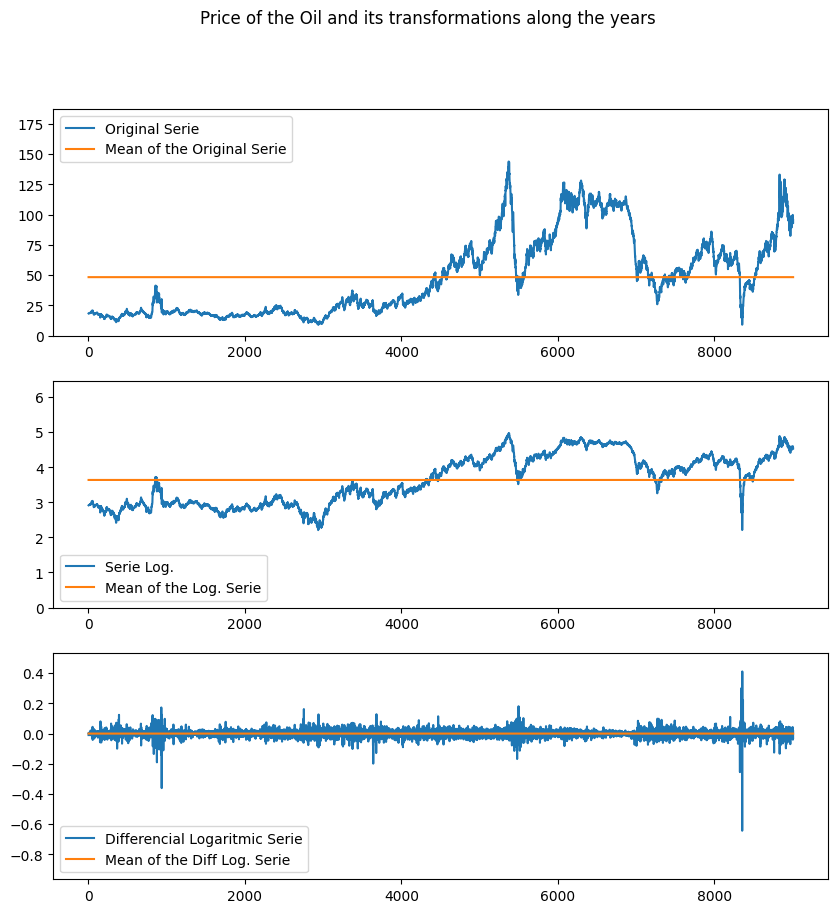

In [7]:
# separar x y la y para el gráfico
x = df.index

y = df["y"]
y_mean = [np.mean(y) for _ in y]

y_log = df["y_log"]
y_log_mean = [np.mean(y_log) for _ in y_log]

y_log_diff = df["y_log_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes
# tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Original Serie")
ax1.plot(x, y_mean, label = "Mean of the Original Serie")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 7.
ax2.plot(x, y_log, label = "Serie Log.")
ax2.plot(x, y_log_mean, label = "Mean of the Log. Serie")
ax2.set_ylim(0, np.max(y_log)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_log_diff, label = "Differencial Logaritmic Serie")
ax3.plot(x, y_log_diff_mean, label = "Mean of the Diff Log. Serie")
ax3.set_ylim(np.min(y_log_diff)*1.5, np.max(y_log_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Price of the Oil and its transformations along the years")

#### Seasonality Check

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or has a unit root. In simpler terms, it helps to check if a time series data set is stable over time or if it shows trends, cycles, or other non-stationary behaviors.

The ADF test is an extension of the Dickey-Fuller test and includes more complex models to account for higher-order autoregressive processes. The test works by testing the null hypothesis that a unit root is present in the time series sample. If the null hypothesis is rejected, it suggests that the time series is stationary

In [8]:
for serie, name_serie in zip([y, y_log, y_log_diff], ["Original Series", "Log Series", "Diff Log Series"]):
    
    print("------------------------------------------------------------------")
    
    print("We are working with the series {}\n".format(name_serie))
    result_analysis = adfuller(serie)
    
    adf_statistic_value = result_analysis[0]
    p_value = result_analysis[1]
    
    print("ADF Statistic Value from the precalculated tables: {}".format(-2.89))
    print("ADF Statistic Value: {}\n".format(adf_statistic_value))
    
    print("Significance Level to consider the series as stationary: {}".format(0.05))
    print("p-value: {}\n".format(p_value))

------------------------------------------------------------------
We are working with the series Original Series

ADF Statistic Value from the precalculated tables: -2.89
ADF Statistic Value: -1.9918544071295257

Significance Level to consider the series as stationary: 0.05
p-value: 0.29015603926422134

------------------------------------------------------------------
We are working with the series Log Series

ADF Statistic Value from the precalculated tables: -2.89
ADF Statistic Value: -1.8032940879348056

Significance Level to consider the series as stationary: 0.05
p-value: 0.37882750115650377

------------------------------------------------------------------
We are working with the series Diff Log Series

ADF Statistic Value from the precalculated tables: -2.89
ADF Statistic Value: -16.427113494485894

Significance Level to consider the series as stationary: 0.05
p-value: 2.4985801611428892e-29



In summary, only the Diff Log Series is stationary (p-value<0.05), while the Original Series and Log Series are not (p-value>0.05).

#### Autocorrelation vs. Partial Autocorrelation

Autocorrelation measures the linear relationship between a time series and its lagged values. In simpler terms, it assesses how much the current value of a series depends on its past values. Autocorrelation is fundamental in time series analysis, helping identify patterns and dependencies within the data.

Interpretation:
- Positive ACF: A positive ACF at lag k indicates a positive correlation between the current observation and the observation at lag k.
- Negative ACF: A negative ACF at lag k indicates a negative correlation between the current observation and the observation at lag k.
- Decay in ACF: The decay in autocorrelation as lag increases often signifies the presence of a trend or seasonality in the time series.
- Significance: Significant ACF values at certain lags may suggest potential patterns or relationships in the time series.

Partial autocorrelation removes the influence of intermediate lags, providing a clearer picture of the direct relationship between a variable and its past values. Unlike autocorrelation, partial autocorrelation focuses on the direct correlation at each lag.

Interpretation:
- Direct Relationship: PACF isolates the direct correlation between the current observation and the observation at lag k, controlling for the influence of lags in between.
- AR Process Identification: Peaks or significant values in PACF at specific lags can indicate potential orders for autoregressive (AR) terms in time series models.
- Modeling Considerations: Analysts often examine PACF to guide the selection of lag orders in autoregressive integrated moving average (ARIMA) models.

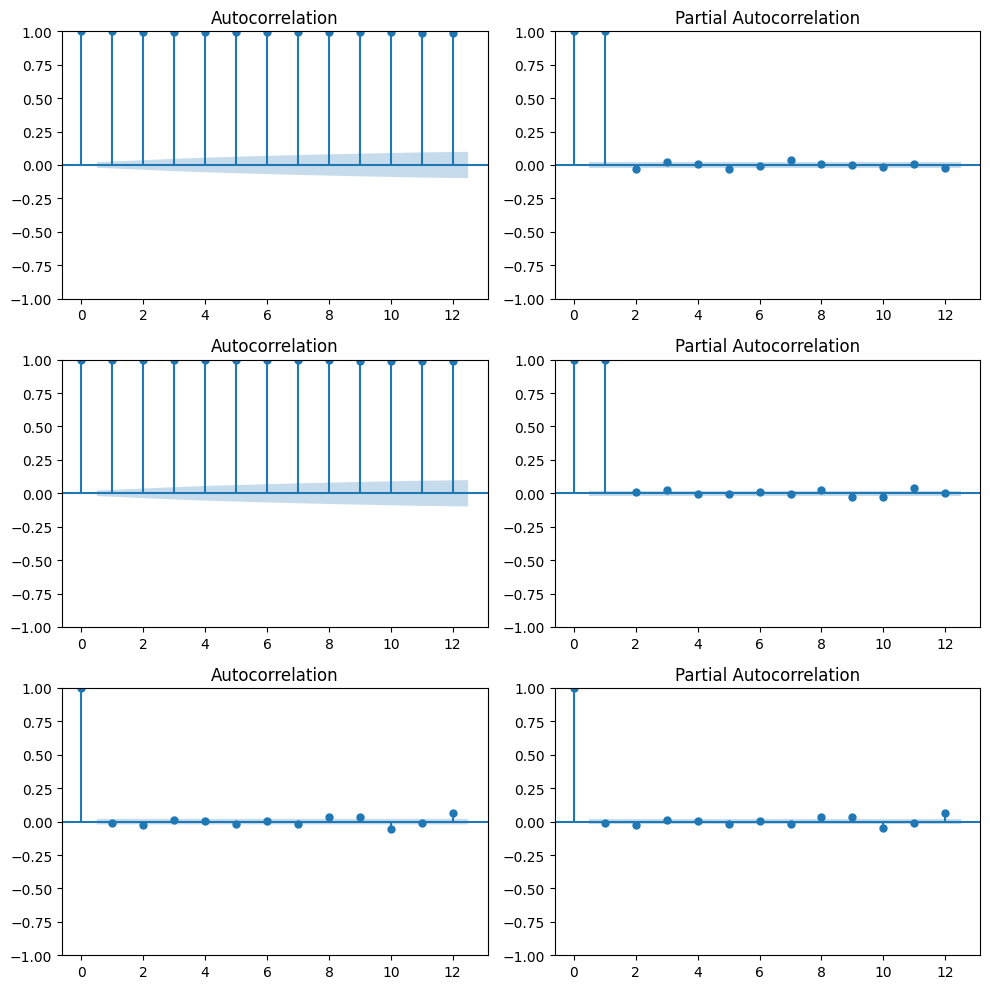

In [10]:
LAGS = 12

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelation")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Partial Autocorrelation")

plot_acf(y_log, ax = ax3, lags = LAGS, title = "Autocorrelation")
plot_pacf(y_log, ax = ax4, lags = LAGS, title = "Partial Autocorrelation")

plot_acf(y_log_diff, ax = ax5, lags = LAGS, title = "Autocorrelation")
plot_pacf(y_log_diff, ax = ax6, lags = LAGS, title = "Partial Autocorrelation")

fig.tight_layout()

The autocorrelation (ACF) graph shows the correlation of the time series with its own values at different lags. Here are some key points:
- High values at initial lags: If the autocorrelation is high at the initial lags and then gradually decreases, this may indicate that the time series has a trend.
- Slow decay pattern: A slow decay in autocorrelation suggests that the series is not stationary and may need differencing to stabilize it.

The partial autocorrelation (PACF) graph shows the correlation of the time series with its own values at different lags, removing the influence of intermediate lags. Here are some key points:
- Significant peaks at specific lags: If there are significant peaks at certain lags, this may indicate the presence of autoregressive (AR) components in the time series.
- Rapid decline: A rapid decline in the PACF after the initial lags may suggest that a low-order AR model could be appropriate.

Conclusions for a Time Series Problem:
- Seasonality and Trend: If the graphs show repetitive patterns or trends, you might need to fit models that account for these components, such as SARIMA (Seasonal ARIMA).
- Stationarity: If the graphs indicate that the series is not stationary, you may need to differentiate the series (subtract the previous value) to stabilize it.
- ARIMA Models: Based on the peaks in the PACF and ACF graphs, you can determine the parameters p (autoregressive) and q (moving average) for an ARIMA model.

**Note:** A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.

## Split train and test

In [11]:
serie_to_predict = y_log

In [12]:
y_index = serie_to_predict.index

date_train = int(len(y_index)*0.9)

y_train = serie_to_predict[y_index[:date_train]]
y_test = serie_to_predict[y_index[date_train:len(y_index)]]

In [13]:
y_train.tail()

8105    4.263102
8106    4.265774
8107    4.279302
8108    4.276805
8109    4.256463
Name: y_log, dtype: float64

In [14]:
y_test.head()

8110    4.275971
8111    4.275971
8112    4.262398
8113    4.263947
8114    4.257172
Name: y_log, dtype: float64

## Models

### ARIMA 

ARIMA stands for Autoregressive Integrated Moving Average. It is a popular statistical method used for time series analysis and forecasting. 

Components of ARIMA:
- Autoregressive (AR) part: This component involves regressing the variable on its own lagged (past) values. The order of the AR part is denoted by 
p, which indicates the number of lagged values included in the model.
- Integrated (I) part: This component involves differencing the data to make it stationary. The order of differencing is denoted by 
d, which indicates the number of times the data has been differenced.
- Moving Average (MA) part: This component involves modeling the error term as a linear combination of error terms from previous time steps. The order of the MA part is denoted by q, which indicates the number of lagged forecast errors included in the model.

Notation
An ARIMA model is typically denoted as ARIMA(p,d,q), where:
- p is the number of lagged values in the autoregressive part.
- d is the number of times the data has been differenced.
- q is the number of lagged forecast errors in the moving average part.

Steps to Build an ARIMA Model
- Identification: Determine if the time series is stationary. If not, apply differencing to achieve stationarity. Identify the values of 
p,d, and q using autocorrelation (ACF) and partial autocorrelation (PACF) plots.
- Estimation: Estimate the parameters of the ARIMA model using the identified values of p, d, and q.
- Diagnostic Checking: Evaluate the model by checking the residuals to ensure they resemble white noise (i.e., they are uncorrelated and have a constant mean and variance).

For time series data with seasonality, the ARIMA model can be extended to include seasonal components. This is known as the SARIMA model, denoted as ARIMA(p,d,q)(P,D,Q)_m, where:
- P, D, and Q are the seasonal autoregressive, differencing, and moving average terms, respectively.
- m is the number of periods in each season.

ARIMA models are widely used in various fields such as finance, economics, and environmental science for forecasting future values based on past data. They are particularly useful for short-term forecasting when the underlying data shows patterns that can be captured by the model.

#### Gridsearch: the search for the optimal parameters for the ARIMA model.

In [15]:
# To perform the grid search, we will calculate the possible values to pass to the model.
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# We will use the SARIMAX model because its implementation in Python includes additional tools
# that facilitate the analysis and are not available in the ARIMA implementation.

# Now, SARIMAX is an ARIMA model but with a seasonal component (the S for Seasonal) and also
# an exogenous component (X for eXogenous regressors).
# Therefore, a SARIMAX model of (1, 1, 1) x (0, 0, 0, 0)
# is an ARIMA model (1, 1, 1).

# If you want to try a full SARIMAX model, execute the following itertools line.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# We leave them at zero to only analyze an ARIMA model.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


In [17]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # save the result
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        except:
            continue

et = time.time()

print("The search of the parameters took {} minutes!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:44005.89651828141
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:32852.85064746736
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:22338.763866305933
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:-38408.70400998521
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:-38408.09013610819
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:-38400.4828086606
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:-33027.120719626895
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:-38385.43692396565
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:-38384.79469698934
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:-38412.520068436745
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:-38411.92836141219
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:-38404.3337960139
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:-38413.745151036215
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:-38406.142626349785
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:-38400.478433852404
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:-35169.787139358596
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:-38390.01756774341
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:-38380.641861678654
ARIMA(2

The AIC index is the Akaike Information Criterion and is used to choose a model from a set of possible models.

The index calculates the Kullback-Leibler distance between the model and the series.

One way to interpret the index is: we look for the model with the lowest index because it is the simplest one that fits the data.

In [18]:
print("The best model is {}, \nwith AIC = {}".format(best_params, best_score))

The best model is (0, 0, 2), 
with AIC = 22338.763866305933


In [19]:
# Training the model with the best parameters.

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

#### Results of the best model

In [20]:
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.9639      0.003    592.633      0.000       1.957       1.970
ma.L2          1.0324      0.003    307.804      0.000       1.026       1.039
sigma2         0.8627      0.044     19.799      0.000       0.777       0.948


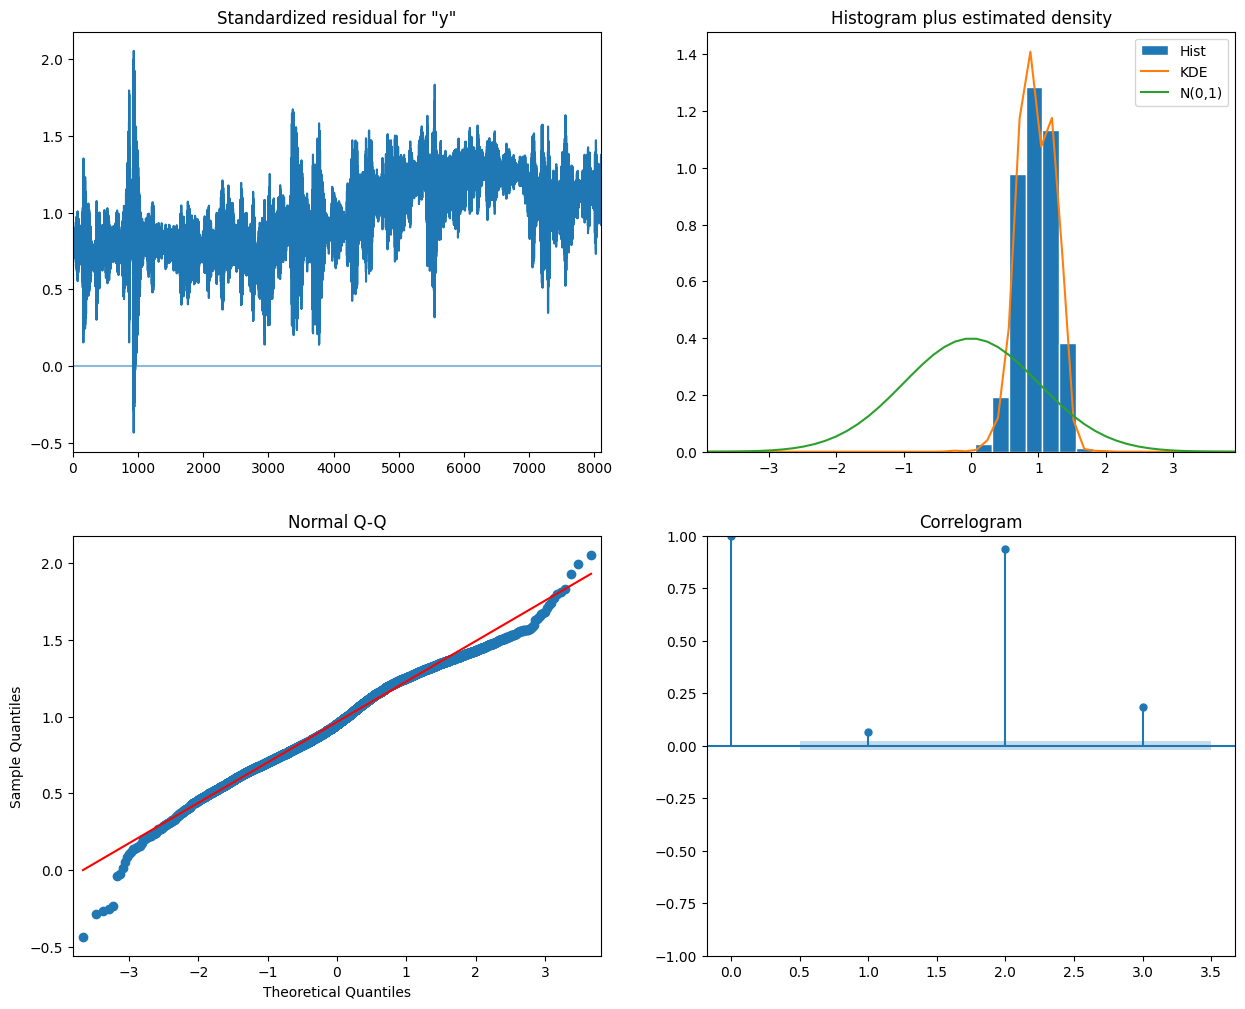

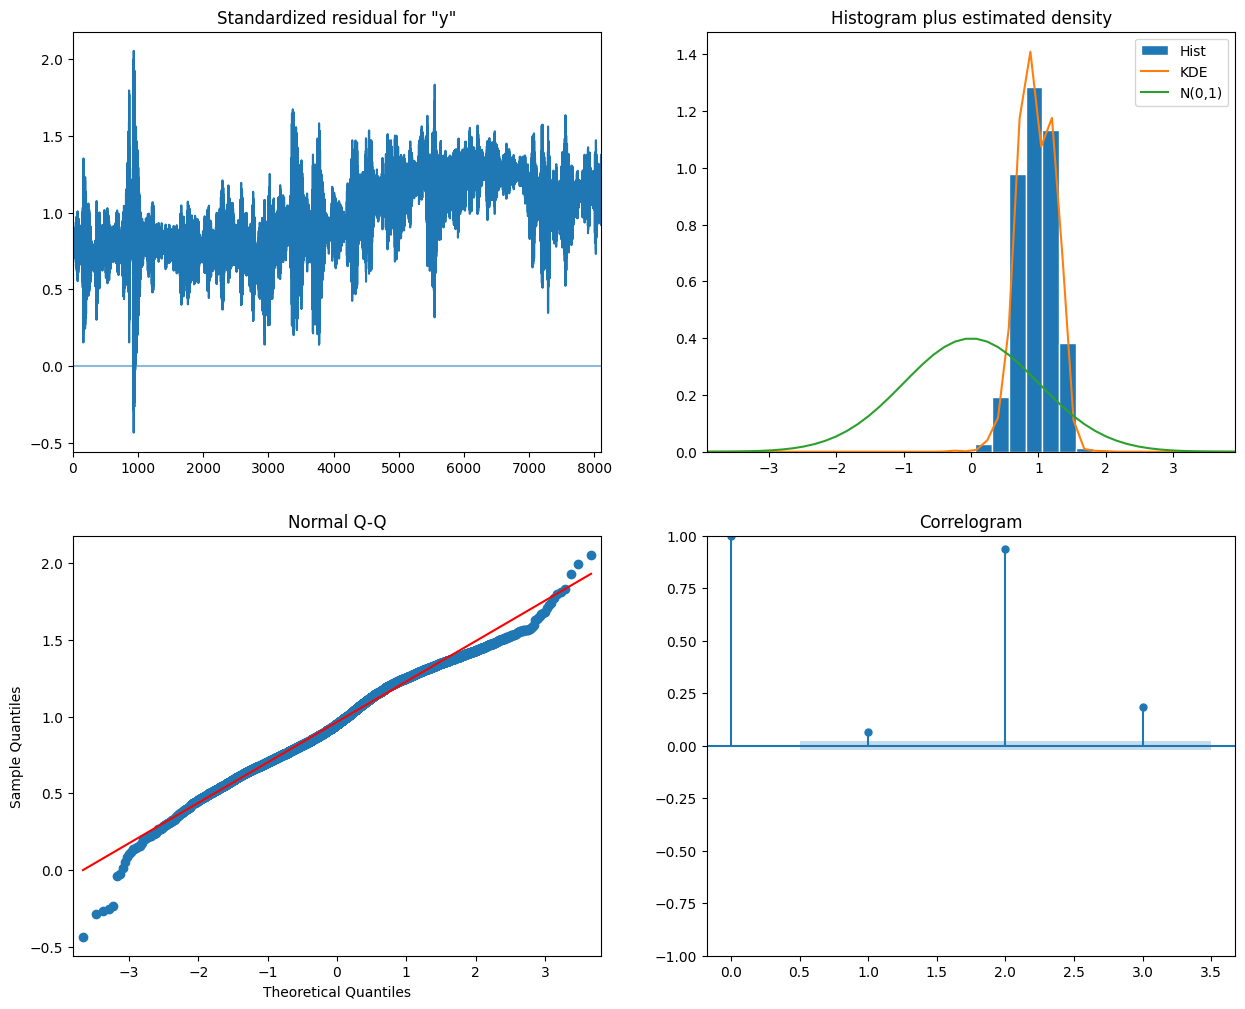

In [21]:
results.plot_diagnostics(figsize = (15, 12), lags = 3)

#### Prediction

In [22]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

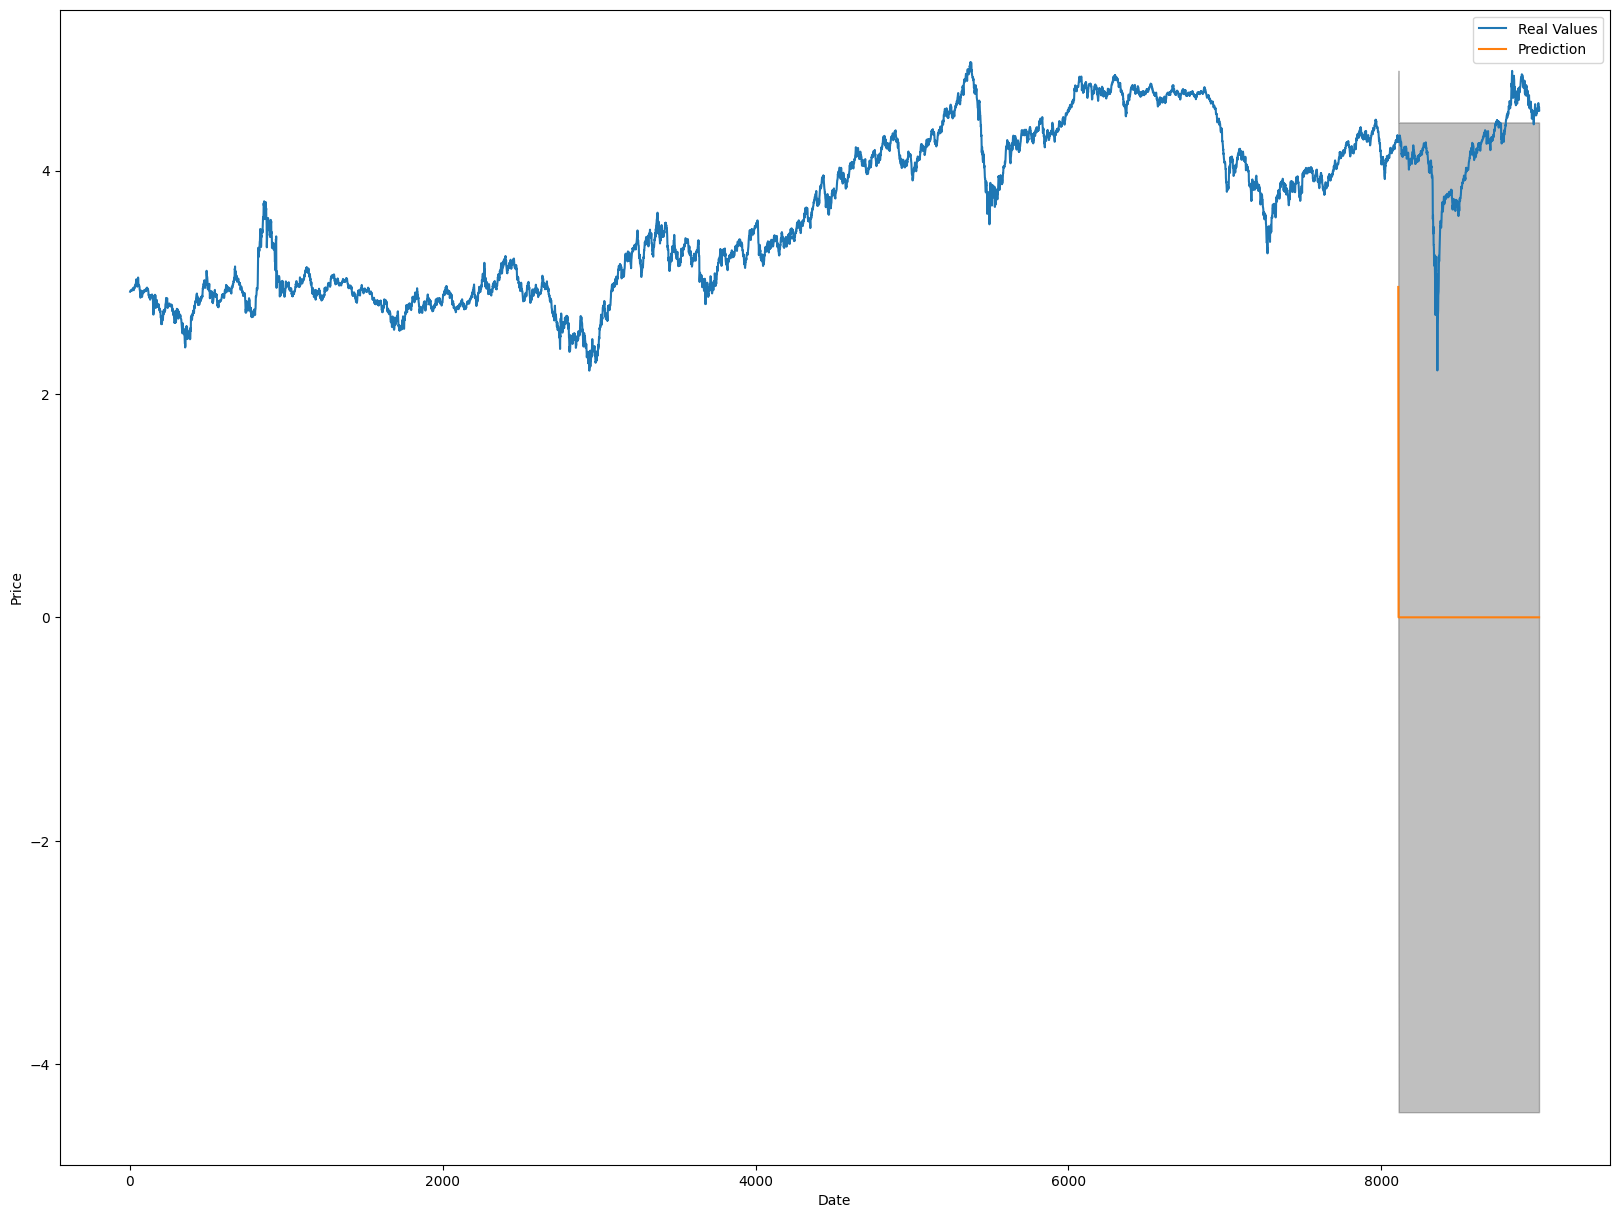

In [23]:
ax = serie_to_predict.plot(label = 'Real Values', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Prediction')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [24]:
y_pred = pred_ci.iloc[:, 0]

In [25]:
# Calculate RMSE
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("ARIMA model with the parameters {} has as result of the rmse in test of {}".format(best_params, round(rmse, 2)))

ARIMA model with the parameters (0, 0, 2) has as result of the rmse in test of 8.6


## PROPHET

Prophet is an open-source forecasting tool developed by Facebook's Core Data Science team. It is designed for time series forecasting and is particularly effective for data with strong seasonal patterns and historical data spanning multiple seasons.

Key Features:
- Additive Model: Prophet uses an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, along with holiday effects. This makes it suitable for time series data with complex seasonal patterns.
- Automatic Forecasting: Prophet is designed to be easy to use and fully automatic. It can generate forecasts with minimal manual intervention, making it accessible for both data scientists and analysts.
- Robustness: The model is robust to missing data and shifts in the trend, and it typically handles outliers well.
- Customizability: While Prophet provides automated forecasts, it also allows for manual adjustments and tuning to improve forecast accuracy.

Prophet is available in both R and Python, making it versatile for different programming environments. 

Prophet is widely used for various applications, including:
- Sales Forecasting: Predicting future sales based on historical data.
- Capacity Planning: Estimating future resource requirements.
- Financial Forecasting: Projecting future financial metrics.
- Demand Forecasting: Anticipating future demand for products or services.

Advantages:
- Ease of Use: Prophet is user-friendly and requires minimal coding to generate forecasts.
- Flexibility: It can handle different types of seasonality and incorporate holiday effects.
- Scalability: Suitable for large datasets and can be used for forecasting at scale.

Prophet is a powerful tool for time series forecasting, especially when dealing with seasonal data. 

In [26]:
# read daily page views for the Wikipedia page for Peyton Manning; scraped into hosted CSV
# conda install -c conda-forge fbprophet (to install)
from prophet import Prophet
plt.rcParams['figure.figsize'] = [14, 4]

df = pd.read_csv('BrentOilPrices.csv')
df["Date"] = pd.to_datetime(df["Date"])
df = df.rename(columns={'Date': 'ds', 'Price': 'y'})

df.head()

Importing plotly failed. Interactive plots will not work.


,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [27]:
# log data due to spikes
# dataframe must have ds column with type datetime and y column which is time series we are trying to predict
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,1987-05-20,2.924773
1,1987-05-21,2.915064
2,1987-05-22,2.920470
3,1987-05-25,2.923162
4,1987-05-26,2.924773


In [28]:
# fit model
model = Prophet()
model.fit(df)

15:59:36 - cmdstanpy - INFO - Chain [1] start processing
15:59:40 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# forecast 365 days into future
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = model.make_future_dataframe(periods=365)
print(future.head())
print(future.tail())

          ds
0 1987-05-20
1 1987-05-21
2 1987-05-22
3 1987-05-25
4 1987-05-26
             ds
9371 2023-11-10
9372 2023-11-11
9373 2023-11-12
9374 2023-11-13
9375 2023-11-14


In [30]:
# populate forecast
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9371,2023-11-10,4.466101,4.179534,4.770716,4.339770,4.609483,0.006012,0.006012,0.006012,0.010060,0.010060,0.010060,-0.004048,-0.004048,-0.004048,0.0,0.0,0.0,4.472113
9372,2023-11-11,4.466334,4.154942,4.699874,4.338310,4.610895,-0.026716,-0.026716,-0.026716,-0.021708,-0.021708,-0.021708,-0.005008,-0.005008,-0.005008,0.0,0.0,0.0,4.439619
9373,2023-11-12,4.466568,4.156024,4.742017,4.336850,4.611686,-0.027596,-0.027596,-0.027596,-0.021708,-0.021708,-0.021708,-0.005888,-0.005888,-0.005888,0.0,0.0,0.0,4.438972
9374,2023-11-13,4.466802,4.188259,4.766193,4.335390,4.612336,0.002865,0.002865,0.002865,0.009565,0.009565,0.009565,-0.006700,-0.006700,-0.006700,0.0,0.0,0.0,4.469667
9375,2023-11-14,4.467035,4.164440,4.764538,4.334049,4.612946,-0.000554,-0.000554,-0.000554,0.006902,0.006902,0.006902,-0.007456,-0.007456,-0.007456,0.0,0.0,0.0,4.466481


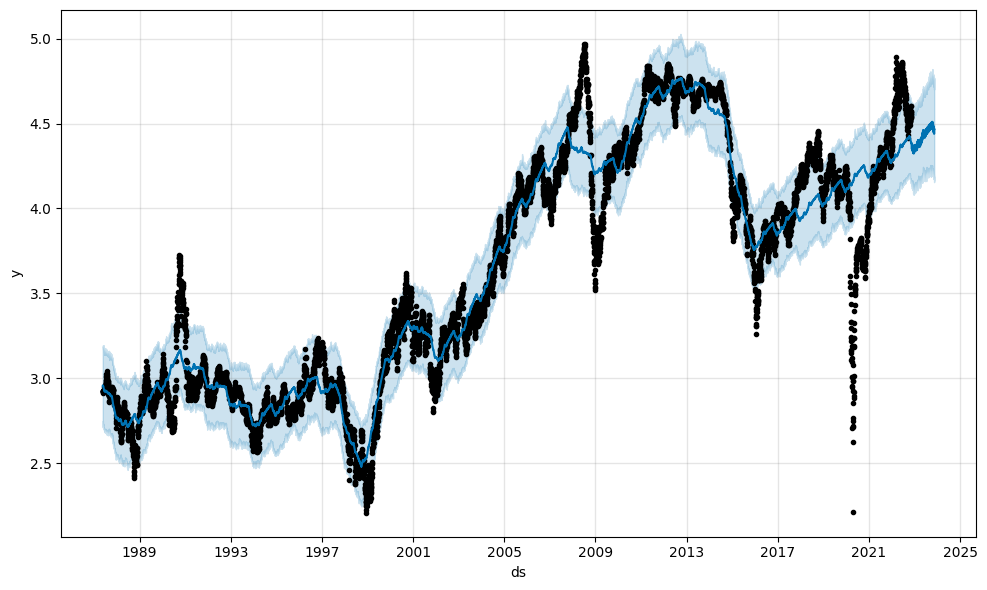

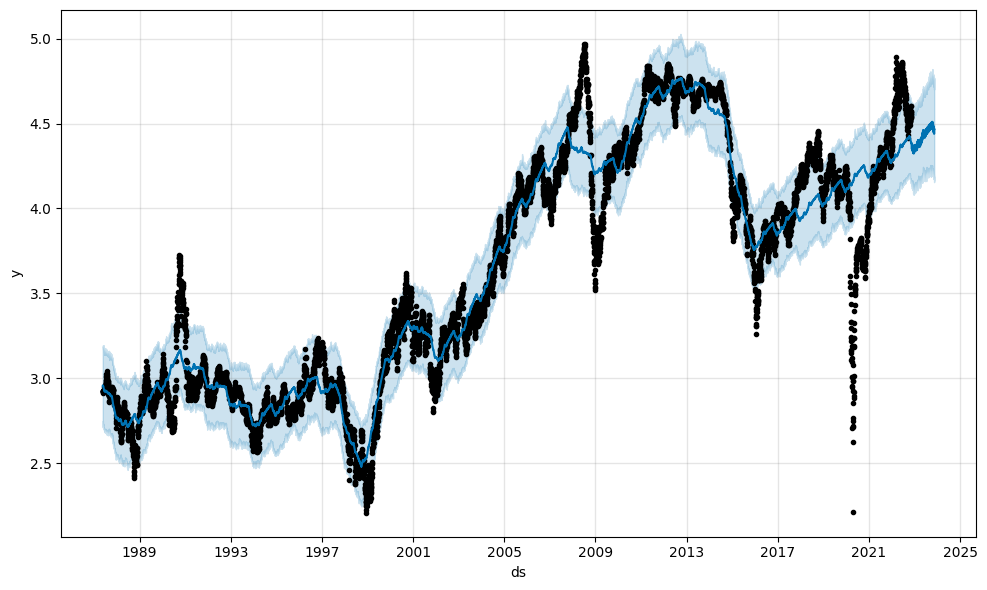

In [31]:
# plot forecast
model.plot(forecast)

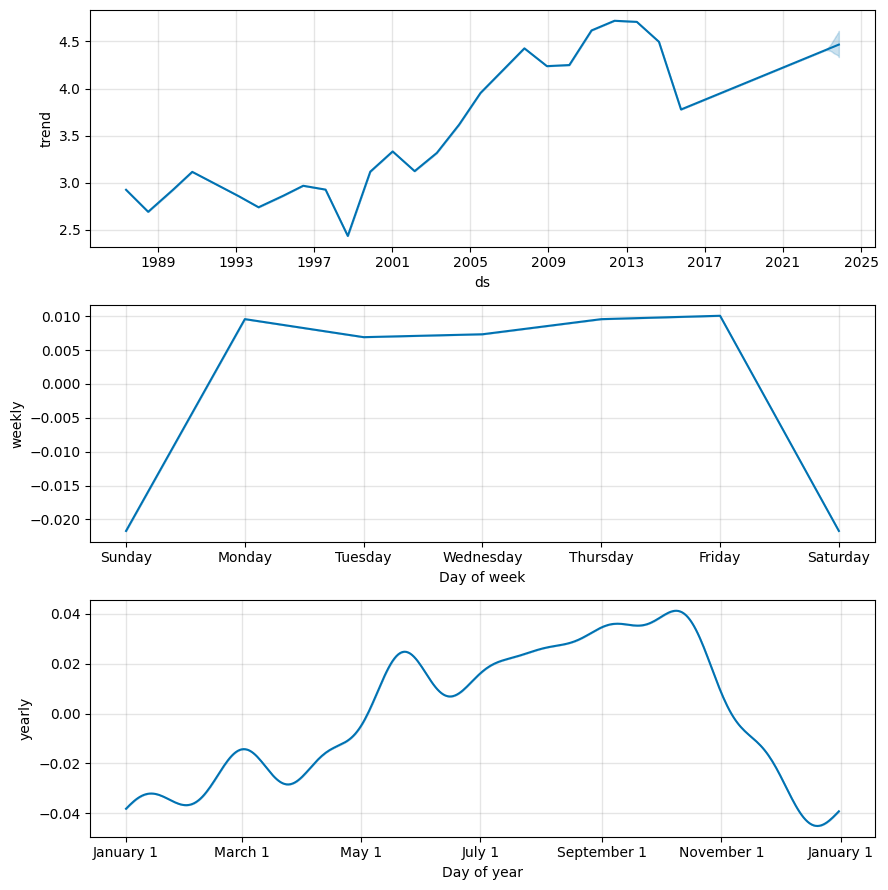

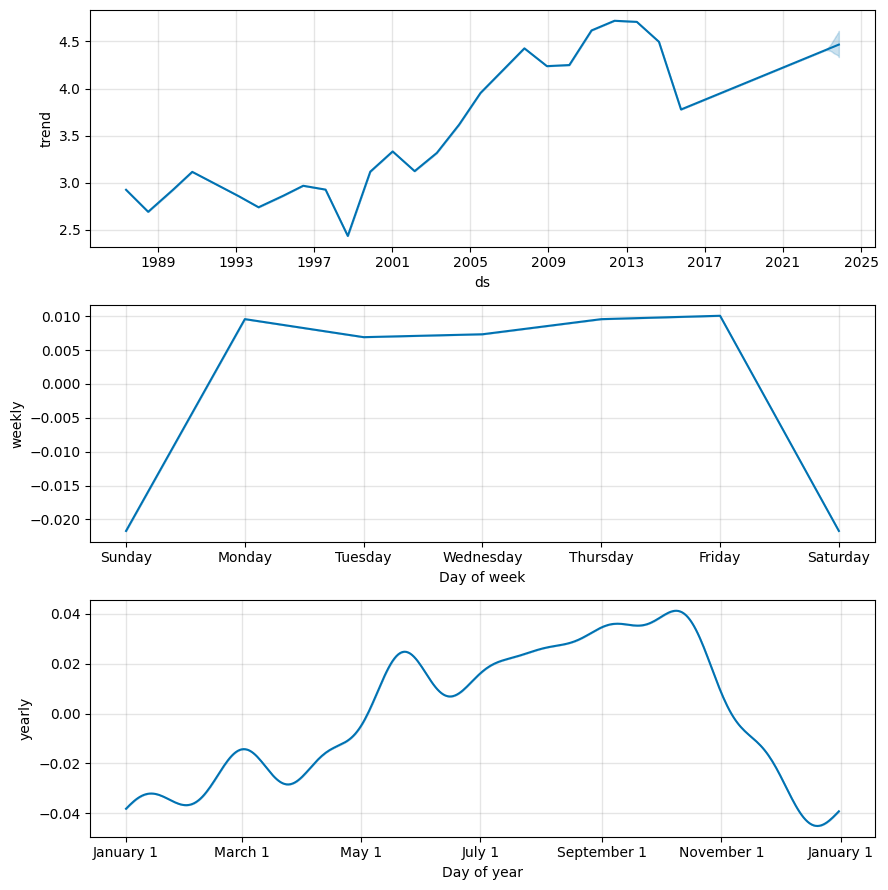

In [ ]:
# plot individual components of forecast: trend, weekly/yearly seasonality
model.plot_components(forecast)